In [13]:
import random
from helpers import *
# random.seed(6)
# np.random.seed(6)
i=0
df = pd.read_csv('/home/guonaixin/trylab/factor-ident/simu_matrix/20Xfull'+str(i+1)+'.csv')
df =df.drop('Unnamed: 0',axis=1)
Z = np.array(df,dtype = 'float64')

# redefine Z to be all the other columns except the last one
n,p= Z.shape
Znorm = normalize_columns(Z)
mu0 = np.mean(Znorm, axis=0)
Sigma0 = np.cov(Znorm.T)
#Gamma0 = np.zeros((p, p))
Gamma0 =np.random.normal(0.0001,0.001,(p,p))
#find best sr
# St = sr_best(Znorm,lambda_val = 0.01, sigma = 500, T = 10000)
# print(St)
St=np.array([ 0, 4, 6, 9, 22])
Z0 = Z[:,St]
Gamma0[St] = np.linalg.inv(Z0.T@Z0)@Z0.T@Z

Gamma = cp.Variable((p,p))
Gamma.value = Gamma0
############ Sigma 1 ###################
Sigma = np.cov((Z-Z@Gamma.value).T)
############ Sigma 2 ###################
# Sigma = (Z-Z@Gamma0).T@(Z-Z@Gamma0)/n
############ Sigma 3 ###################
# k=5
# U, S, V =  np.linalg.svd(Z)
# Z_approx = U[:, :k] @ np.diag(S[:k]) @ V[:k, :]
# # Calculate the difference between the rank-k approximation and the actual values
# difference = Z - Z_approx
# Sigma = np.cov(np.transpose(difference), rowvar=True)  
# Sigma_inverse = np.linalg.inv(covariance_matrix) / 10**17

S,U=np.linalg.eig(Sigma)
Sigma_half_inv =U@np.diag(np.sqrt(1/S))@U.T/ 10**13

for i in range(1):
    objective = cp.Minimize(cp.norm( Sigma_half_inv @ Z.T - Sigma_half_inv @ Gamma.T @ Z.T  , 'fro')**2)
    # Define the constraint
    constraints = [
        cp.sum(cp.norm(Gamma, 2, axis=1))<=5
    ]
    # Define the optimization problem
    problem = cp.Problem(objective, constraints)
    # Solve the optimization problem
    result = problem.solve()

St0= chosen_set_with_press(Gamma.value,5,Znorm)[0]
print(np.linalg.norm(Gamma.value, axis=1))
print(St0,'sr',sr(np.linalg.solve(Sigma0[St0][:, St0], mu0[St0]), mu0[St0], Sigma0[St0][:, St0]) )


[8.74469887e-05 1.45996978e-05 2.33585915e-05 1.56420666e-05
 4.01194894e-05 5.61678507e-05 1.66474207e-05 7.15353929e-08
 1.61434127e-05 1.27314027e-04 8.16909296e-06 2.34963023e-05
 1.70911911e-05 1.32638001e-05 6.09953854e-06 1.55389300e-05
 2.05690640e-06 1.44902626e-05 7.71637947e-06 1.55911962e-05
 5.36333600e-06 1.10601985e-05 6.74591805e-05 1.06074225e-05
 5.29169198e-06]
[9, 0, 22, 5, 4] sr 0.10560294716641169


In [18]:

import numpy as np

import pandas as pd
import warnings

from helpers import *

warnings.filterwarnings('ignore')
fama285_ = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
df99 = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]
df22 = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/X22_22.csv')
dff22 = df22[df22.columns[1:]]
df99['Unnamed: 0'] = fama285_['Date']
df22['Unnamed: 0'] = fama285_['Date']

initial Index(['STR', 'REG', 'HMLM', 'PEAD', 'IVOL', 'QMJ', 'EPRD', 'IMD', 'Abr1',
       'DP', 'CLA', 'dROE1', 'MKTRF', 'IA', 'BAB', 'IAq1', 'SMB', 'CMA', 'OPA',
       'ISq1', 'dPIA', 'LIQ', 'NI', 'dFIN', 'COP', 'ILR1', 'CIM1', 'dLTI',
       'SIM1', 'FIN', 'ILE1', 'ISFF1', 'ME', 'HS', 'RER', 'OP', 'ETR', 'r1a',
       'IR', 'ETL'],
      dtype='object')
opt Index(['EPRD', 'ME', 'HMLM', 'REG', 'IVOL', 'PEAD'], dtype='object')
sr 0.4838745541756356


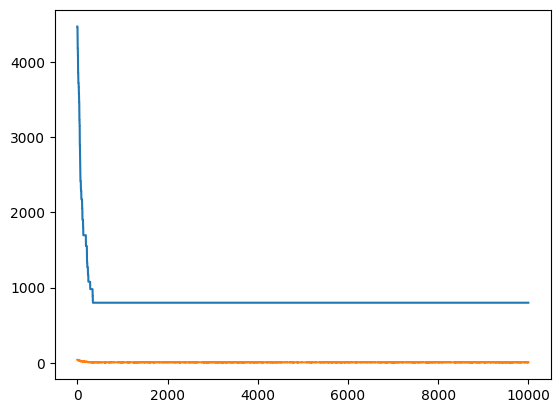

In [59]:
from helpers import  *
Z = dff99.values
Z = normalize_columns(Z)
T =10000
sigma =100
lambd =100
k = 9#or 9

n, p = Z.shape
Mh = compute_k_truncated_svd(Z, k)[0]  # Perform k-truncated SVD of Z

# Calculate sample mean and sample covariance matrix

# n, p = Z.shape
# U = np.zeros((n, k))
alpha_hat = np.zeros(p)
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)   


# alpha_hat = np.abs(np.mean(Z - Mh, axis=0))
# Sigma = np.cov((Z - Mh).T)
S,U=np.linalg.eig(Sigma)
S = np.abs(S)


Sigma_inv = np.linalg.inv(Sigma)
# Initialize S1 with indices of top 2k largest values of alpha_i / sqrt(Sigma_ii)
indices = np.argsort(alpha_hat / np.sqrt(np.diag(Sigma)))[::-1][:40]
print('initial', dff99.columns[indices])

St = set(indices)
Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
Theta = np.linalg.inv(Z_St.T @ Z_St) @ Z_St.T  @ Z 
SRwPenalty = np.zeros(T)
#record the subset selection in each MH update
Sseq = np.zeros((p, T))


for t in range(T):
    j = np.random.randint(p)  # Generate a random index
    # Create new subset S_new by adding or removing j
    
    if j in St:
        S_new = St - {j}
    else:
        S_new = St | {j}
        
    Z_S_new = np.concatenate((np.ones((n,1)),Z[:, list(S_new)]),axis=1)    
    Theta_new = np.linalg.inv(Z_S_new.T @ Z_S_new) @ Z_S_new.T  @ Z 

    # Calculate the new Theta and acceptance probability
   
    # acceptance_prob = np.exp(
    #     -sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
    #     - lambd * len(S_new)
    #     +sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
    #     + lambd * len(St)
    # )
    acceptance_prob = np.exp(
        -sigma * Theta_new[0]@ Sigma_inv @Theta_new[0].T
        -lambd * len(S_new)
        +sigma * Theta[0]@ Sigma_inv @Theta[0].T
        + lambd * len(St)
    )
    
    # Set the new subset S_t+1 with probability according to acceptance probability
    if np.random.rand() < acceptance_prob:
        St = S_new
        Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
        Theta = np.linalg.inv(Z_St.T @ Z_St) @ Z_St.T  @ Z 
    Sseq[list(S_new), t] = 1
    #record Sharpe ratio + penalty
    SRwPenalty[t] =  sigma * Theta[0] @ Sigma_inv @Theta[0].T + lambd * len(St)
    if SRwPenalty[t]<0:
        print(SRwPenalty[t], Theta[0] @ Sigma_inv @Theta[0].T )
import matplotlib.pyplot as plt
#Plots
plt.plot(SRwPenalty)
plt.plot(np.sum(Sseq, axis=0))    
sridx = np.argmin(SRwPenalty)
#Find the indices of selected factors
Sopt = np.where(Sseq[:, sridx])[0]
print('opt',dff99.columns[Sopt])

mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[Sopt][:, Sopt], mu[Sopt])
print('sr',sr(wt, mu[Sopt], Sigma[Sopt][:, Sopt]))

    

initial Index(['STR', 'REG', 'HMLM', 'PEAD', 'IVOL', 'QMJ', 'EPRD', 'IMD', 'Abr1',
       'DP', 'CLA', 'dROE1', 'MKTRF', 'IA', 'BAB', 'IAq1', 'SMB', 'CMA', 'OPA',
       'ISq1', 'dPIA', 'LIQ', 'NI', 'dFIN', 'COP', 'ILR1', 'CIM1', 'dLTI',
       'SIM1', 'FIN', 'ILE1', 'ISFF1', 'ME', 'HS', 'RER', 'OP', 'ETR', 'r1a',
       'IR', 'ETL'],
      dtype='object')
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 34, 35, 37, 38, 41, 42, 43, 47, 58, 59, 65, 72, 77, 78, 81, 83, 84, 85, 86, 87, 89, 90, 92, 94, 95, 97, 98}
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 34, 35, 37, 38, 41, 42, 43, 47, 58, 59, 65, 72, 77, 81, 83, 84, 85, 86, 87, 89, 90, 92, 94, 95, 97, 98}
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 34, 35, 37, 38, 41, 42, 43, 47, 58, 59, 65, 72, 77, 81, 83, 84, 85, 86, 87, 89, 90, 92, 94, 97, 98}
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 34, 35, 37, 38, 41, 42, 43, 47, 58, 59, 65, 70, 72, 77, 81, 83, 84, 85, 86, 87, 89, 90, 92, 94, 97, 98}
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 

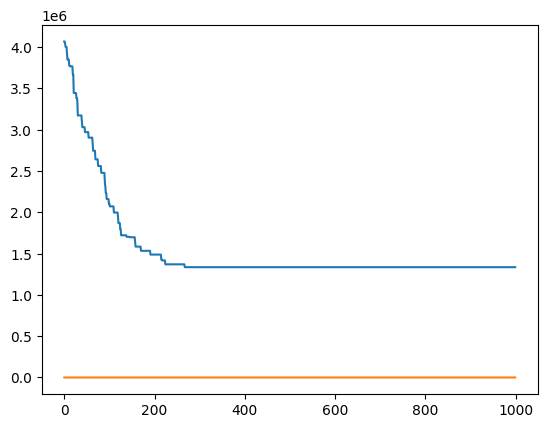

In [67]:
from helpers import  *
Z = dff99.values
Z = normalize_columns(Z)
T =1000
sigma = 0.6
lambd1 =40000
lambd2 =80000
k = 9 # or 9

n, p = Z.shape
Mh = compute_k_truncated_svd(Z, k)[0]  # Perform k-truncated SVD of Z

# Calculate sample mean and sample covariance matrix

# n, p = Z.shape
# U = np.zeros((n, k))
alpha_hat = np.zeros(p)
e1 = np.eye(p+1)[0]
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)   


# alpha_hat = np.abs(np.mean(Z - Mh, axis=0))
# Sigma = np.cov((Z - Mh).T)
S,U=np.linalg.eig(Sigma)
S = np.abs(S)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_half_inv =np.linalg.inv(U@np.diag(np.sqrt(S))@U.T)
# Initialize S1 with indices of top 2k largest values of alpha_i / sqrt(Sigma_ii)
indices = np.argsort(alpha_hat / np.sqrt(np.diag(Sigma)))[::-1][:40]
print('initial', dff99.columns[indices])

St = set(indices)
Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
SRwPenalty = np.zeros(T)
#record the subset selection in each MH update
Sseq = np.zeros((p, T))


for t in range(T):
    j = np.random.randint(p)  # Generate a random index
    # Create new subset S_new by adding or removing j
    
    if j in St:
        S_new = St - {j}
    else:
        S_new = St | {j}
        
    Z_S_new = np.concatenate((np.ones((n,1)),Z[:, list(S_new)]),axis=1)    
    Theta_new = np.linalg.inv(Z_S_new.T @ Z_S_new+lambd1*e1@e1.T) @ Z_S_new.T  @ Z 

    # Calculate the new Theta and acceptance probability
   
    # acceptance_prob = np.exp(
    #     -sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
    #     - lambd * len(S_new)
    #     +sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
    #     + lambd * len(St)
    # )
    acceptance_prob = np.exp(-sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
        -lambd1 * Theta_new[0]@ Sigma_inv @Theta_new[0].T
        -lambd2 * len(S_new)
        +sigma * np.linalg.norm((Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
        +lambd1 * Theta[0]@ Sigma_inv @Theta[0].T
        + lambd2 * len(St)
        
    )
    
    # Set the new subset S_t+1 with probability according to acceptance probability
    if np.random.rand() < acceptance_prob:
        St = S_new
        print(St)
        Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
        Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
    Sseq[list(S_new), t] = 1
    #record Sharpe ratio + penalty
    SRwPenalty[t] =  sigma * np.linalg.norm((Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2+lambd1 * Theta[0]@ Sigma_inv @Theta[0].T + lambd2 * len(St)
   
import matplotlib.pyplot as plt
#Plots
plt.plot(SRwPenalty)
plt.plot(np.sum(Sseq, axis=0))    
sridx = np.argmin(SRwPenalty)
#Find the indices of selected factors
Sopt = np.where(Sseq[:, sridx])[0]
print('opt',dff99.columns[Sopt])

mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[Sopt][:, Sopt], mu[Sopt])
print('sr',sr(wt, mu[Sopt], Sigma[Sopt][:, Sopt]))

    

opt Index(['COP', 'ME', 'SGq1', 'REG'], dtype='object')
sr 0.1825196567429313
objective 14489032.627822798
aSa 6286872.35736026
RSS 2202160.2704625363


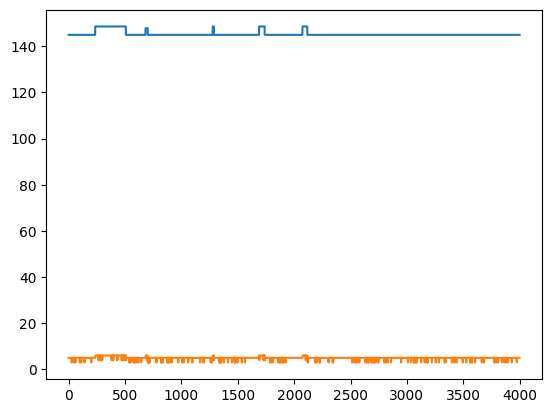

In [35]:
from helpers import  *
import numpy as np

import pandas as pd
import warnings


warnings.filterwarnings('ignore')
fama285_ = pd.read_csv('empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
df99 = pd.read_csv('empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values
Z = normalize_columns(Z)
T = 5000
sigma =0.00001
lambd1 =5/sigma
k = 12
lambd2 = 15/sigma

n, p = Z.shape
Mh = compute_k_truncated_svd(Z, k)[0]  # Perform k-truncated SVD of Z

# Calculate sample mean and sample covariance matrix

# n, p = Z.shape
# U = np.zeros((n, k))
alpha_hat = np.zeros(p)
e1 = np.eye(p+1)[0]
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)   


# alpha_hat = np.abs(np.mean(Z - Mh, axis=0))
# Sigma = np.cov((Z - Mh).T)
S,U=np.linalg.eig(Sigma)
S = np.abs(S)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_half_inv =np.linalg.inv(U@np.diag(np.sqrt(S))@U.T)
# Initialize S1 with indices of top 2k largest values of alpha_i / sqrt(Sigma_ii)
indices = np.argsort(alpha_hat / np.sqrt(np.diag(Sigma)))[::-1][:30]
#print('initial', dff99.columns[indices])

St = set(indices)
Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
Objective = np.zeros(T)
aSa = np.zeros(T)
RSS = np.zeros(T)
#record the subset selection in each MH update
Sseq = np.zeros((p, T))


for t in range(T):
    j = np.random.randint(p)  # Generate a random index
    # Create new subset S_new by adding or removing j
    
    if j in St:
        S_new = St - {j}
    else:
        S_new = St | {j}
        
    Z_S_new = np.concatenate((np.ones((n,1)),Z[:, list(S_new)]),axis=1)    
    Theta_new = np.linalg.inv(Z_S_new.T @ Z_S_new+lambd1*e1@e1.T) @ Z_S_new.T  @ Z 

    # Calculate the new Theta and acceptance probability
   
    # acceptance_prob = np.exp(
    #     -sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
    #     - lambd * len(S_new)
    #     +sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
    #     + lambd * len(St)
    # )
    acceptance_prob = np.exp(sigma * (-np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
        -lambd1 * Theta_new[0]@ Sigma_inv @Theta_new[0].T
        -lambd2 * len(S_new)
        + np.linalg.norm((Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
        +lambd1 * Theta[0]@ Sigma_inv @Theta[0].T
        + lambd2 * len(St)
    ))
    
    # Set the new subset S_t+1 with probability according to acceptance probability
    if np.random.rand() < acceptance_prob:
        St = S_new
        #print(St)
        Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
        Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
    Sseq[list(S_new), t] = 1
    #record Sharpe ratio + penalty
    Objective[t] =  np.linalg.norm((Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2+lambd1 * Theta[0]@ Sigma_inv @Theta[0].T + lambd2 * len(St)
    aSa[t] = Theta[0]@ Sigma_inv @Theta[0].T
    RSS[t] = np.linalg.norm((Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
import matplotlib.pyplot as plt
#Plots
plt.plot(Objective[1000:]/100000)
plt.plot(np.sum(Sseq[:,1000:], axis=0))    
sridx = np.argmin(Objective)
#Find the indices of selected factors
Sopt = np.where(Sseq[:, sridx])[0]
print('opt',dff99.columns[Sopt])

mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[Sopt][:, Sopt], mu[Sopt])
print('sr',sr(wt, mu[Sopt], Sigma[Sopt][:, Sopt]))
print('objective', Objective[sridx])
print('aSa', lambd1*aSa[sridx])
print('RSS', RSS[sridx])

In [11]:
Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, list(Sopt)]),axis=1)    
Theta=np.linalg.inv(Z_Sopt.T @ Z_Sopt+lambd1*e1@e1.T) @ Z_Sopt.T  @ Z
np.sum(np.linalg.norm(Theta@Sigma_half_inv,axis=1))

5235.3514613311745

In [ ]:
Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, list(Sopt)]),axis=1)    
Theta=np.linalg.inv(Z_Sopt.T @ Z_Sopt+lambd1*e1@e1.T) @ Z_Sopt.T  @ Z
np.sum(np.linalg.norm(Theta,axis=1))

19.716747709665434

# Optimize Theta

In [152]:
############# Optimize Theta ################
from helpers import  *
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
fama285_ = pd.read_csv('empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
df99 = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values
Z = normalize_columns(Z)

n, p = Z.shape
svd_C =10
k = 9
lambd = 8/0.00001
# Define the optimization variable Gamma

alpha_hat = np.zeros(p)
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)  
S,U=np.linalg.eig(Sigma)
S = np.abs(S)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_half_inv =np.linalg.inv(U@np.diag(np.sqrt(S))@U.T)
Gamma = cp.Variable((p+1,p))
# Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, Sopt]),axis=1)
e1 = (np.eye(p+1)[0][:,np.newaxis])

# Theta = np.linalg.inv(Z_Sopt.T @ Z_Sopt+lambd1*e1@e1.T) @ Z_Sopt.T  @ Z 
# Gamma0 =np.zeros((p+1,p))
# Gamma0[0] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[0]
# Gamma0[Sopt] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[1:]
# Gamma.value = Gamma0
Z1 = np.concatenate((np.ones((n,1)),Z[:,:]),axis=1)

######################### OPT #####################################
Opt_matrix1 = np.concatenate((Z@Sigma_half_inv, np.zeros((1,p))),axis=0)
Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
    
objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2
                                @Gamma@Sigma_half_inv, 'fro')**2 )
# Define the constraint
constraints = [
    cp.sum(cp.norm(Gamma[1:], 2, axis=1))<=svd_C
]
# Define the optimization problem
problem = cp.Problem(objective, constraints)
# Solve the optimization problem
result = problem.solve(solver=cp.SCS)



In [2]:

chosen_set=chosen_set_with_press((Gamma.value)[1:],6,Z)[0]
print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
print('sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))

[88, 89, 90, 91, 92, 93] ['LTR' 'REG' 'IVOL' 'SUE' 'IA' 'ROE']
sr 0.31175882415678985


# try small set in X_s

In [4]:
############change small
df99 = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values
Z = normalize_columns(Z)

n, p = Z.shape
svd_C =2/0.001
k = 9
lambd = 2/0.001
# Define the optimization variable Gamma

alpha_hat = np.zeros(p)
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)  
S,U=np.linalg.eig(Sigma)
S = np.abs(S)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_half_inv =np.linalg.inv(U@np.diag(np.sqrt(S))@U.T)

# Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, Sopt]),axis=1)
# Theta = np.linalg.inv(Z_Sopt.T @ Z_Sopt+lambd1*e1@e1.T) @ Z_Sopt.T  @ Z 
# Gamma0 =np.zeros((p+1,p))
# Gamma0[0] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[0]
# Gamma0[Sopt] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[1:]
# Gamma.value = Gamma0
Sopt0 =[]
for i in ['ILR1', 'CMA', 'STR', 'REG', 'IVOL', 'PEAD','OCP', 'MKTRF', 'IA','BETA','CLA']:
    Sopt0.append(list(dff99.columns).index(i))
Sopt0+=[0,1,2,3,4,5,6,7,8,9,10]
Sopt = Sopt0
Z1 = np.concatenate((np.ones((n,1)),Z[:,Sopt]),axis=1)
e1 = (np.eye(len(Sopt)+1)[0][:,np.newaxis])
Gamma = cp.Variable((len(Sopt)+1,p))
######################### OPT #####################################
Opt_matrix1 = np.concatenate((Z@Sigma_half_inv, np.zeros((1,p))),axis=0)
Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
    
objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2
                                @Gamma@Sigma_half_inv, 'fro')**2 )
# Define the constraint
constraints = [
    cp.sum(cp.norm(Gamma[1:], 2, axis=1))<=svd_C
]
# Define the optimization problem
problem = cp.Problem(objective, constraints)
# Solve the optimization problem
result = problem.solve(solver=cp.MOSEK, warm_start = True)


In [5]:
# chosen_set=chosen_set_with_press((B.value @ Sigma_half_inv)[1:],6,Z)[0]
chosen_set=chosen_set_with_press((Gamma.value)[1:],6,Z[:,Sopt])[0]
print(chosen_set,np.array(dff99.columns)[np.array(Sopt)[chosen_set]])

mu = np.mean(Z[:,Sopt], axis=0)
Sigma = np.cov(Z[:,Sopt].T)
wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
print('sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))

[7, 17, 16, 4, 1, 8] ['MKTRF' 'COP' 'CLA' 'IVOL' 'CMA' 'IA']
sr 0.169846323609881


# Optimize B



In [ ]:
from helpers import  *
import numpy as np
import pandas as pd
import warnings
from itertools import combinations

df99= pd.read_csv('/home/guonaixin/trylab/factor-ident/simu_matrix/600_100_5Xfull_sr2.csv')
dff99 = df99[df99.columns[1:]]
Z = dff99.values
Z = normalize_columns(Z)
srsr = 0
mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
for chosen_set in combinations(list(range(100)), 5):
    chosen_set = list(chosen_set)
    wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
    if sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]) >srsr:
        srsr = sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set])
        print(chosen_set)



In [21]:
#B
from helpers import  *
import numpy as np
import pandas as pd
import warnings
from itertools import combinations
df99 = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/X99_22.csv')

dff99 = df99[df99.columns[1:]]

Z = dff99.values
Z = normalize_columns(Z)

n, p = Z.shape
svd_C=100

k = 9
lambd = 2/0.00001
# Define the optimization variable Gamma

alpha_hat = np.zeros(p)
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)  
S,U=np.linalg.eig(Sigma)
S = np.abs(S)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_half = U@np.diag(np.sqrt(S))@U.T
Sigma_half_inv =np.linalg.inv(Sigma_half)

Gamma = cp.Variable((p+1,p))
# Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, Sopt]),axis=1)
# e1 = (np.eye(len(Sopt)+1)[0][:,np.newaxis])
# Theta = np.linalg.inv(Z_Sopt.T @ Z_Sopt+lambd1*e1@e1.T) @ Z_Sopt.T  @ Z 
# Gamma0 = np.zeros((p+1,p))
# Gamma0[0] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[0]
# Gamma0[Sopt] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[1:]
# Gamma.value = Gamma0
B = cp.Variable((p+1,p))
# B.value =  Gamma0 @ Sigma_half
Z1 = np.concatenate((np.ones((n,1)),Z ),axis=1)
######################### OPT #####################################
Opt_matrix1 = np.concatenate((Z@Sigma_half_inv, np.zeros((1,p))),axis=0)
e1 = (np.eye(p+1)[0][:,np.newaxis])
Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
    
objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2
                                @ B, 'fro')**2 )
# Define the constraint
# constraints = [
#     cp.sum(cp.norm((B @ Sigma_half)[1:] , 2, axis=1))<=svd_C
# ]

constraints = [
    cp.sum(cp.norm((B )[1:] , 2, axis=1))<=svd_C
]
# Define the optimization problem
problem = cp.Problem(objective, constraints)
# Solve the optimization problem
result = problem.solve(solver=cp.SCS)


In [22]:
#B
chosen_set=chosen_set_with_press((B.value @ Sigma_half)[1:],6,Z)[0]
print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
print('sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))

[98, 27, 12, 11, 81, 83] ['FIN' 'EBP' 'dCOA' 'dBE' 'CMA' 'HMLM']
sr 0.04449141096285333


In [20]:
np.round(np.linalg.norm(B.value,axis=1),3)

array([2.7600e-01, 0.0000e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03,
       2.0000e-03, 0.0000e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03,
       0.0000e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03, 0.0000e+00,
       0.0000e+00, 1.0000e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03, 0.0000e+00,
       0.0000e+00, 1.0000e-03, 0.0000e+00, 4.1800e+01, 1.0000e-03,
       1.0000e-03, 1.0000e-03, 1.0000e-03, 0.0000e+00, 0.0000e+00,
       1.0000e-03, 1.0000e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e-03, 1.0000e-03, 0.0000e+00, 1.0000e-03,
       0.0000e+00, 1.0000e-03, 4.2700e-01, 2.0000e-03, 1.0000e-03,
       0.0000e+00, 0.0000e+00, 2.0000e-03, 2.0000e-03, 0.0000e+00,
       1.0000e-03, 1.0000e-03, 1.0000e-03, 2.0000e-03, 1.0000e-03,
       1.0000e-03, 2.0000e-03, 2.0000e-03, 0.0000e+00, 1.0000e-03,
       1.0000e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e-03,
       2.0000e-03, 0.0000e+00, 1.0000e-03, 0.0000e+00, 1.0000e

In [7]:
(B.value@Sigma_half_inv[0])

array([ 2.23256213e-01,  1.35361487e+03,  7.69195439e+01,  1.18500521e+02,
       -7.10294520e+02,  1.75347153e+02,  3.55892097e+02,  6.47892088e+02,
        9.18735987e+02, -8.42811750e+02, -2.46435499e+01,  1.39868441e+02,
       -2.11002290e+02, -2.67876885e+02,  5.30549992e+01, -5.06490517e+01,
        1.40762066e+01, -8.93604474e+01, -7.97367705e+01, -2.05868910e+02,
       -1.21366751e+02, -1.43353492e+01, -1.42894376e+02, -1.34167581e+02,
        5.95766320e+02,  6.51484389e+02, -5.67240619e+02,  1.02964762e+02,
       -9.75891471e+02, -5.02749384e+02, -6.01672529e+02,  9.27167884e+02,
        8.55241073e+01,  3.40720810e+01,  2.57571954e+02,  1.18553102e+02,
       -4.81048093e+02,  1.72794777e+01,  5.92401642e+02,  4.38129178e+02,
        7.17111928e+02,  3.10803336e+02, -8.51436943e+02,  1.49013051e+02,
        2.60814863e+01,  6.46939280e+01,  5.75904425e+01,  5.56501587e+02,
       -4.24207215e+02, -6.79480602e+01,  8.09694003e+02,  2.60101370e+02,
       -1.27236569e+02,  

In [104]:
# Z_Sopt = np.concatenate((np.ones((n,1)),Z[:, Sopt]),axis=1)
# Gamma0 =np.zeros((p+1,p))
# Gamma0[0] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[0]
# Gamma0[Sopt] = (np.linalg.pinv(Z_Sopt.T@Z_Sopt)@Z_Sopt.T@Z)[1:]
# Gamma0

In [ ]:
## m-h & grouplasso

from helpers import  *
import numpy as np

import pandas as pd
import warnings


warnings.filterwarnings('ignore')
fama285_ = pd.read_csv('empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
df99 = pd.read_csv('empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values
Z = normalize_columns(Z)
T = 5000
sigma =0.0001
lambd1 =2/sigma
k = 9
lambd2 = 5/sigma

n, p = Z.shape
Mh = compute_k_truncated_svd(Z, k)[0]  # Perform k-truncated SVD of Z

# Calculate sample mean and sample covariance matrix

# n, p = Z.shape
# U = np.zeros((n, k))
for _ in range(300):
    alpha_hat = np.zeros(p)
    e1 = np.eye(p+1)[0]
    Z_hat = np.zeros_like(Z)
    for i in range(p):
        Z_minus_i = np.delete(Z, i, axis=1)
        Ui,Si,Vi = np.linalg.svd(Z_minus_i)
        X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
        beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
        alpha_hat[i]=beta[0]
        Z_hat[:, i] = np.dot(X, beta)
    Sigma = np.cov(Z - Z_hat, rowvar=False)   


    # alpha_hat = np.abs(np.mean(Z - Mh, axis=0))
    # Sigma = np.cov((Z - Mh).T)
    S,U=np.linalg.eig(Sigma)
    S = np.abs(S)
    Sigma_inv = np.linalg.inv(Sigma)
    Sigma_half_inv =np.linalg.inv(U@np.diag(np.sqrt(S))@U.T)
    # Initialize S1 with indices of top 2k largest values of alpha_i / sqrt(Sigma_ii)
    indices = np.argsort(alpha_hat / np.sqrt(np.diag(Sigma)))[::-1][:30]
    #print('initial', dff99.columns[indices])

    St = set(indices)
    Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
    Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
    e1_t = (np.eye(len(St)+1)[0][:,np.newaxis])
    Opt_matrix2_t= np.concatenate((Z_St, np.sqrt(lambd1)*e1_t.T),axis=0)
        
    Objective = np.zeros(T)
    aSa = np.zeros(T)
    RSS = np.zeros(T)
    #record the subset selection in each MH update
    Sseq = np.zeros((p, T))


    for t in range(T):
        j = np.random.randint(p)  # Generate a random index
        # Create new subset S_new by adding or removing j
        
        if j in St:
            S_new = St - {j}
        else:
            S_new = St | {j}
            
        Z_S_new = np.concatenate((np.ones((n,1)),Z[:, list(S_new)]),axis=1)    
        Theta_new = np.linalg.inv(Z_S_new.T @ Z_S_new+lambd1*e1@e1.T) @ Z_S_new.T  @ Z 

        # Calculate the new Theta and acceptance probability
        
        # B.value =  Gamma0 @ Sigma_half
    
        ######################### OPT #####################################
        Opt_matrix1 = np.concatenate((Z@Sigma_half_inv, np.zeros((1,p))),axis=0)
        e1_new = (np.eye(len(S_new)+1)[0][:,np.newaxis])
        Opt_matrix2_new = np.concatenate((Z_S_new, np.sqrt(lambd1)*e1_new.T),axis=0)
        
        acceptance_prob = np.exp(sigma * (-np.linalg.norm(Opt_matrix1  - (Opt_matrix2_new @  Theta_new @ Sigma_half_inv), 'fro')**2
            -lambd2 *  np.sum(np.linalg.norm((Theta_new)[1:], 2, axis=1))

            + np.linalg.norm(Opt_matrix1  - (Opt_matrix2_t @  Theta @ Sigma_half_inv), 'fro')**2
            + lambd2 *  np.sum(np.linalg.norm((Theta)[1:], 2, axis=1))
        ))
        
        # Set the new subset S_t+1 with probability according to acceptance probability
        if np.random.rand() < acceptance_prob:
            St = S_new
            #print(St)
            Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
            Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
            e1_t = (np.eye(len(St)+1)[0][:,np.newaxis])
            Opt_matrix2_t= np.concatenate((Z_St, np.sqrt(lambd1)*e1_t.T),axis=0)
        
        Sseq[list(S_new), t] = 1
        #record Sharpe ratio + penalty
        Objective[t] = np.linalg.norm(Opt_matrix1  - (Opt_matrix2_t @  Theta @ Sigma_half_inv), 'fro')**2  + lambd2 *  np.sum(np.linalg.norm((Theta)[1:], 2, axis=1))
        aSa[t] = Theta[0]@ Sigma_inv @Theta[0].T
        RSS[t] = np.linalg.norm(Opt_matrix1  - (Opt_matrix2_t @  Theta @ Sigma_half_inv), 'fro')**2
    import matplotlib.pyplot as plt
    print(len(Sopt))
    #Plots
    # plt.plot(Objective[1000:]/80000)
    # plt.plot(np.sum(Sseq[:,1000:], axis=0))    
    sridx = np.argmin(Objective)
    #Find the indices of selected factors
    Sopt = np.where(Sseq[:, sridx])[0]
    if len(Sopt)==6:
        print('opt',dff99.columns[Sopt])

        mu = np.mean(Z, axis=0)
        Sigma = np.cov(Z.T)
        wt = np.linalg.solve(Sigma[Sopt][:, Sopt], mu[Sopt])
        print('sr',sr(wt, mu[Sopt], Sigma[Sopt][:, Sopt]))
        print('objective', Objective[sridx])
        print('aSa', lambd1*aSa[sridx])
        print('RSS', RSS[sridx])


# simulation

In [3]:

from helpers import *

# df99 = pd.read_csv('empirical_data/X99_22.csv')


# k = 8
thousand =10
lambd = 10*thousand #control alpha
# lambd2 = 450000 #control sparisty
par=1
Lambd2 = [20*thousand]
K =[5]
# Define the optimization variable Gamma
for i in range(100):
    df99= pd.read_csv('/home/guonaixin/trylab/factor-ident/simu_matrix/600_100_5Xfull_sr'+str(i+1)+'.csv')
    dff99 = df99[df99.columns[1:]]
    Z = dff99.values
    Z = normalize_columns(Z)

    n, p = Z.shape
    for lambd2 in Lambd2:
        for k in K:
            alpha_hat = np.zeros(p)
            Z_hat = np.zeros_like(Z)
            for i in range(p):
                Z_minus_i = np.delete(Z, i, axis=1)
                Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
                beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
                alpha_hat[i]=beta[0]
                Z_hat[:, i] = np.dot(X, beta)
            Sigma = np.cov(Z - Z_hat, rowvar=False)  
            S,U=np.linalg.eig(Sigma)
            #S = np.abs(S)
            Sigma_inv = np.linalg.inv(Sigma)
            Sigma_half = U@np.diag(np.sqrt(S))@U.T
            Sigma_half_inv =np.linalg.inv(Sigma_half)

            Sigma_half_diag = np.diag(np.diagonal(Sigma_half))
            alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
            
            #Gamma = cp.Variable((p+1,p))

            B = cp.Variable((p+1,p))
            # B.value =  Gamma0 @ Sigma_half
            Z1 = np.concatenate((np.ones((n,1)),Z ),axis=1)
            ######################### OPT #####################################
            Opt_matrix1 = np.concatenate((Z@Sigma_half_inv, np.zeros((1,p))),axis=0)
            e1 = (np.eye(p+1)[0][:,np.newaxis])
            Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
                
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 )
            #constraints = [cp.sum(cp.norm((B @ Sigma_half)[1:] , 2, axis=1))<=svd_C]
            # Define the optimization problem
            #problem = cp.Problem(objective, constraints)

            objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B @ Sigma_half)[1:] , 2, axis=1)))
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm((B)[1:,:] , 2, axis=1)))
            problem = cp.Problem(objective)

            # Solve the optimization problem
            result = problem.solve(solver=cp.MOSEK)
            B_opt = B.value

            row_norms = np.linalg.norm((B.value @ Sigma_half), axis=1)  # Calculate the row norms
            # print(np.sum(row_norms[1:]))
            residual = np.linalg.norm(Opt_matrix1 - Opt_matrix2@ B.value, axis = 1)
            # print('RSS:', result)
            # print('aSa:', residual[-1]**2)
            # Get the indices of the top 10 rows with largest row norms
            
            nonzero = np.count_nonzero(np.round(row_norms[1:],4))
            chosen_set = np.argsort(row_norms[1:])[::-1][:nonzero]
             
            print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
            mu = np.mean(Z, axis=0)
            Sigma = np.cov(Z.T)
            wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
            
            print(lambd2,par,k,'sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]),nonzero)
            # plt.hist(row_norms)
            
            
            print(np.linalg.norm((Z@Sigma_half_inv - Z1@ B.value), 'fro')**2  )
           
            print('deleting p52w6')
            B.value[62]=np.zeros(p)
            print(np.linalg.norm((Z@Sigma_half_inv - Z1@ B.value), 'fro')**2  )
           
         

[2 1 4 0] ['X3' 'X2' 'X5' 'X1']
200 1 5 sr 0.1386932061493 4
60211.435507135924
deleting p52w6
60211.435507263726
[2 1 0 3 4] ['X3' 'X2' 'X1' 'X4' 'X5']
200 1 5 sr 0.23306181673109944 5
60327.16334669585
deleting p52w6
60327.16334685706
[ 2  3  0  4  1 40] ['X3' 'X4' 'X1' 'X5' 'X2' 'Y36']
200 1 5 sr 0.15005568131983735 6
60567.26894301221
deleting p52w6
60567.26894364918
[2 0 3 1] ['X3' 'X1' 'X4' 'X2']
200 1 5 sr 0.16677611799059555 4
60170.38556948083
deleting p52w6
60170.38556951899
[2 0 3 1 4] ['X3' 'X1' 'X4' 'X2' 'X5']
200 1 5 sr 0.20103908206727675 5
59681.05784839292
deleting p52w6
59681.05785425724
[2 0 3 4 1] ['X3' 'X1' 'X4' 'X5' 'X2']
200 1 5 sr 0.15352586209856506 5
60362.56134634676
deleting p52w6
60362.56134650646
[2 0 3 1 4] ['X3' 'X1' 'X4' 'X2' 'X5']
200 1 5 sr 0.17306188677304166 5
59837.42564943753
deleting p52w6
59837.42564943385
[1 2 0 4] ['X2' 'X3' 'X1' 'X5']
200 1 5 sr 0.1519781032801666 4
60505.89932268197
deleting p52w6
60505.89932302752
[2 0 1 3 4] ['X3' 'X1' 'X2

# Try

In [1]:
from helpers import *

df99 = pd.read_csv('empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values


# Z = (Z-np.mean(Z,axis = 0))/np.std(Z,axis = 0)
Z = normalize_columns(Z)
n, p = Z.shape

# k = 8
thousand =1000
lambd = 1*thousand #control alpha
# lambd2 = 450000 #control sparisty
PAR = [0.9]
# Lambd2 = [60*thousand,150*thousand,180*thousand]
# K =[12,25,30,70]
Lambd2 = [24*thousand]
K =[12]
# Define the optimization variable Gamma'
for k in K:
    for par in PAR:
        for lambd2 in Lambd2:
            alpha_hat = np.zeros(p)
            Z_hat = np.zeros_like(Z)
            for i in range(p):
                
                Z_minus_i = np.delete(Z * (np.abs(np.mean(Z,axis = 0))/np.std(Z,axis = 0)), i, axis=1)
                
                Ui,Si,Vi = np.linalg.svd(Z_minus_i)
                X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
                beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
               
                alpha_hat[i]=beta[0]
                Z_hat[:, i] = np.dot(X, beta)
            Sigma = np.cov(Z - Z_hat, rowvar=False)  
            S,U=np.linalg.eig(Sigma)
            #S = np.abs(S)
            Sigma_inv = np.linalg.inv(Sigma)
            Sigma_half = U@np.diag(np.sqrt(S))@U.T
            Sigma_half_inv =np.linalg.inv(Sigma_half)

            Sigma_half_diag = np.diag(np.diagonal(Sigma_half))
            alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
            
            #Gamma = cp.Variable((p+1,p))

            B = cp.Variable((p+1,p))
            # B.value =  Gamma0 @ Sigma_half
            Z1 = np.concatenate((np.ones((n,1)),Z ),axis=1)
            ######################### OPT #####################################
            Opt_matrix1 = np.concatenate((Z@Sigma_half_inv, np.zeros((1,p))),axis=0)
            e1 = (np.eye(p+1)[0][:,np.newaxis])
            Opt_matrix2 = np.concatenate((Z1, np.sqrt(lambd)*e1.T),axis=0)
                
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 )
            #constraints = [cp.sum(cp.norm((B @ Sigma_half)[1:] , 2, axis=1))<=svd_C]
            # Define the optimization problem
            #problem = cp.Problem(objective, constraints)

            # objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B @ Sigma_half)[1:] , 2, axis=1)))
            objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm(np.diag(1/alpha_z_score**par)@(B @ Sigma_half)[1:] , 2, axis=1)))
            
            
            
            
            #objective = cp.Minimize(cp.norm(Opt_matrix1 - Opt_matrix2@ B, 'fro')**2 +lambd2*cp.sum(cp.norm((B)[1:,:] , 2, axis=1)))
            problem = cp.Problem(objective)

            # Solve the optimization problem
            result = problem.solve(solver=cp.MOSEK)
            B_opt = B.value

            row_norms = np.linalg.norm((B.value @ Sigma_half), axis=1)  # Calculate the row norms
            # print(np.sum(row_norms[1:]))
            residual = np.linalg.norm(Opt_matrix1 - Opt_matrix2@ B.value, axis = 1)
            # print('RSS:', result)
            # print('aSa:', residual[-1]**2)
            # Get the indices of the top 10 rows with largest row norms
            chosen_set = np.argsort(row_norms[1:])[::-1][:6]

            print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
            mu = np.mean(Z, axis=0)
            Sigma = np.cov(Z.T)
            wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
            nonzero = np.count_nonzero(np.round(row_norms[1:],4))
            print(lambd2,par,k,'sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]),nonzero)
            # plt.hist(row_norms)
            
            
            print(np.linalg.norm((Z@Sigma_half_inv - Z1@ B.value), 'fro')**2  )
           
            print('deleting p52w6')
            # B.value[62]=np.zeros(p)
            print(np.linalg.norm((Z@Sigma_half_inv - Z1@ B.value), 'fro')**2  )


[84 83 92 61 89 30] ['QMJ' 'HMLM' 'IA' 'P52W6' 'REG' 'EPRD']
24000 0.9 12 sr 0.2128430975202907 7
531621.1276283244
deleting p52w6
531621.1276283244


In [8]:
np.array(dff99.columns)[np.argsort(np.diag(Sigma))]

array(['REG', 'PEAD', 'BAB', 'dROE1', 'Abr1', 'ROE', 'IA', 'FIN', 'QMJ',
       'IOCA', 'CMA', 'NOA', 'IG', 'NI', 'dROA1', 'IMD', 'COP', 'UMD',
       'ROE1', 'Resid111', 'CIM1', 'dPIA', 'CEI', 'dNOA', 'EPRD', 'OLEq1',
       'PDA', 'dNCO', 'NOP', 'SIM1', 'POA', 'dNCA', 'RMW', 'CLA', 'STR',
       'MKTRF', 'ILE1', 'ROA1', 'SUE', 'DAC', 'OCP', 'ILR1', 'r1a', 'OPA',
       'dWC', 'dLNO', 'ISFF1', 'PTA', 'IM1', 'OL', 'SP', 'IVC', 'ISq1',
       'OCA', 'EM', 'HML', 'LIQ', 'GPA', 'RS1', 'IVOL', 'OP', 'IVG',
       'IAq1', 'HMLM', 'dFNL', 'ETR', 'dII', 'ACI', 'ATO', 'RER', 'BM',
       'NXF', 'TA', 'LTR', 'dBE', 'CTO', 'dCOA', 'P52W6', 'CP', 'NDF',
       'SGq1', 'ETL', 'dLTI', 'NEI1', 'IR', 'Dur', 'IVq1', 'HS', 'OPE',
       'EP', 'OA', 'EBP', 'VHP', 'dFIN', 'SMB', 'TV1', 'DP', 'ME', 'BETA'],
      dtype=object)

In [64]:
np.sort(np.diag(Sigma))[::-1]

array([0.00166943, 0.0016688 , 0.00166523, 0.00166517, 0.00166301,
       0.00166271, 0.00166199, 0.00166189, 0.00166187, 0.0016618 ,
       0.00166176, 0.00166161, 0.00166152, 0.00166149, 0.00166145,
       0.00166118, 0.00166112, 0.00166098, 0.00166038, 0.00165978,
       0.0016594 , 0.00165935, 0.0016592 , 0.0016584 , 0.00165784,
       0.00165774, 0.00165716, 0.00165714, 0.00165697, 0.00165692,
       0.00165663, 0.0016566 , 0.00165643, 0.00165611, 0.00165598,
       0.00165578, 0.00165535, 0.00165454, 0.0016539 , 0.00165383,
       0.00165347, 0.00165285, 0.00165278, 0.00165166, 0.00165139,
       0.00165114, 0.00165101, 0.00165086, 0.00165042, 0.00165021,
       0.00165006, 0.00164983, 0.00164972, 0.00164964, 0.00164952,
       0.00164908, 0.0016477 , 0.00164715, 0.00164699, 0.00164583,
       0.00164467, 0.00164464, 0.00164449, 0.00164438, 0.00164279,
       0.00164163, 0.0016416 , 0.00164066, 0.00164034, 0.00164015,
       0.00164002, 0.00163951, 0.00163915, 0.00163883, 0.00163

In [33]:
from helpers import *

df99 = pd.read_csv('empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]

Z = dff99.values
Z = normalize_columns(Z)
np.sum(np.linalg.svd(Z)[1][:60])/np.sum(np.linalg.svd(Z)[1])

0.8343653096044554

In [42]:
for k in range(10,90):
    alpha_hat = np.zeros(p)
    Z_hat = np.zeros_like(Z)
    for i in range(p):
        Z_minus_i = np.delete(Z, i, axis=1)
        Ui,Si,Vi = np.linalg.svd(Z_minus_i)
        X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
        beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
        alpha_hat[i]=beta[0]
        Z_hat[:, i] = np.dot(X, beta)
    Sigma = np.cov(Z - Z_hat, rowvar=False)  
    S,U=np.linalg.eig(Sigma)
    #S = np.abs(S)
    Sigma_inv = np.linalg.inv(Sigma)
    Sigma_half = U@np.diag(np.sqrt(S))@U.T
    Sigma_half_inv =np.linalg.inv(Sigma_half)

    Sigma_half_diag = np.diag(np.diagonal(Sigma_half))
    alpha_z_score = np.abs(alpha_hat) / np.diagonal(Sigma_half)
    print(k,np.array(dff99.columns)[np.argsort(np.abs(alpha_hat)/np.diag(Sigma_half) )[::-1]][:15])

10 ['STR' 'HMLM' 'REG' 'PEAD' 'IMD' 'MKTRF' 'QMJ' 'P52W6' 'EPRD' 'Abr1' 'CLA'
 'dROE1' 'DP' 'IA' 'dPIA']
11 ['STR' 'HMLM' 'REG' 'PEAD' 'IMD' 'MKTRF' 'QMJ' 'EPRD' 'P52W6' 'Abr1' 'DP'
 'dROE1' 'CLA' 'IA' 'dPIA']
12 ['STR' 'HMLM' 'REG' 'PEAD' 'IMD' 'MKTRF' 'QMJ' 'EPRD' 'Abr1' 'P52W6' 'BAB'
 'OL' 'SUE' 'CLA' 'DP']
13 ['STR' 'HMLM' 'REG' 'PEAD' 'IMD' 'MKTRF' 'QMJ' 'P52W6' 'EPRD' 'Abr1' 'BAB'
 'SUE' 'OL' 'DP' 'dROE1']
14 ['STR' 'HMLM' 'REG' 'PEAD' 'QMJ' 'P52W6' 'IMD' 'EPRD' 'SMB' 'MKTRF' 'BAB'
 'Abr1' 'CLA' 'DP' 'dROE1']
15 ['STR' 'REG' 'HMLM' 'PEAD' 'QMJ' 'P52W6' 'SMB' 'EPRD' 'IMD' 'BAB' 'Abr1'
 'CLA' 'dROE1' 'DP' 'SUE']
16 ['STR' 'HMLM' 'REG' 'PEAD' 'QMJ' 'P52W6' 'EPRD' 'SMB' 'IMD' 'BAB' 'Abr1'
 'DP' 'CLA' 'dROE1' 'CIM1']
17 ['STR' 'HMLM' 'REG' 'QMJ' 'PEAD' 'P52W6' 'SMB' 'EPRD' 'BAB' 'IMD' 'Abr1'
 'CLA' 'dROE1' 'DP' 'SUE']
18 ['STR' 'HMLM' 'REG' 'QMJ' 'PEAD' 'P52W6' 'SMB' 'EPRD' 'BAB' 'IMD' 'Abr1'
 'CLA' 'dROE1' 'DP' 'SUE']
19 ['STR' 'REG' 'HMLM' 'QMJ' 'PEAD' 'P52W6' 'SMB' 'EPRD' 'IMD' 'BA

In [ ]:
# 130000 0.9 9 sr 0.2879602712502759 5
# [83 84 89 61 87] ['HMLM', 'REG', 'QMJ' ,'P52W6' ,'MKTRF']

# [83 84 89 87 90 30] ['HMLM' 'QMJ' 'REG' 'STR' 'IVOL' 'EPRD']
# 8000 3 50 sr 0.25232537223963536 5

In [ ]:
chosen_set = np.argsort(row_norms[1:])[::-1][:5]

print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
print(lambd2,par,k,'sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))

[87 83 13 97 89] ['STR' 'HMLM' 'dFIN' 'PEAD' 'REG']
100 0.9 12 sr 0.3594842851797229


In [117]:
row_norms = np.linalg.norm((B.value @ Sigma_half), axis=1)  # Calculate the row norms
print(np.sum(row_norms[1:]))
residual = np.linalg.norm(Opt_matrix1 - Opt_matrix2@ B.value, axis = 1)
print('RSS:', result)
print('aSa:', residual[-1]**2)
# Get the indices of the top 10 rows with largest row norms
chosen_set = np.argsort(row_norms[1:])[::-1][:6]

print(chosen_set,np.array(dff99.columns)[np.array(chosen_set)])
mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[chosen_set][:, chosen_set], mu[chosen_set])
print('sr',sr(wt, mu[chosen_set], Sigma[chosen_set][:, chosen_set]))
# plt.hist(row_norms)
#50000,150000 12
# 5000 150000 9

3.500542714192768
RSS: 4143363.5452019074
aSa: 213.73257581351746
[83 84 89 87 97 94] ['HMLM' 'QMJ' 'REG' 'STR' 'PEAD' 'IMD']
sr 0.4308343384813194
